# claudette

> Claudette is Claude's friend

In [ ]:
#| hide

from nbdev import show_doc
from fastcore.utils import *
from IPython import display

> **NB**: If you are reading this in GitHub's readme, we recommend you instead read the much more nicely formatted [documentation format](https://claudette.answer.ai/) of this tutorial.

*Claudette* is a wrapper for Anthropic's [Python SDK](https://github.com/anthropics/anthropic-sdk-python).

The SDK works well, but it is quite low level -- it leaves the developer to do a lot of stuff manually. That's a lot of extra work and boilerplate! Claudette automates pretty much everything that can be automated, whilst providing full control. Amongst the features provided:

- A `Chat` class that creates stateful dialogs
- Support for *prefill*, which tells Claude what to use as the first few words of its response
- Convenient image support
- Simple and convenient support for Claude's new Tool Use API.

You'll need to set the `ANTHROPIC_API_KEY` environment variable to the key provided to you by Anthropic in order to use this library.

Note that this library is the first ever "literate nbdev" project. That means that the actual source code for the library is a rendered Jupyter Notebook which includes callout notes and tips, HTML tables and images, detailed explanations, and teaches *how* and *why* the code is written the way it is. Even if you've never used the Anthropic Python SDK or Claude API before, you should be able to read the source code. Click [Claudette's Source](https://claudette.answer.ai/core.html) to read it, or clone the git repo and execute the notebook yourself to see every step of the creation process in action. The tutorial below includes links to API details which will take you to relevant parts of the source. The reason this project is a new kind of literal program is because we take seriously Knuth's call to action, that we have a "*moral commitment*" to never write an "*illiterate program*" -- and so we have a commitment to making literate programming and easy and pleasant experience. (For more on this, see [this talk](https://www.youtube.com/watch?v=rX1yGxJijsI) from Hamel Husain.)

> "*Let us change our traditional attitude to the construction of programs: Instead of imagining that our main task is to instruct a **computer** what to do, let us concentrate rather on explaining to **human beings** what we want a computer to do.*" Donald E. Knuth, [Literate Programming](https://www.cs.tufts.edu/~nr/cs257/archive/literate-programming/01-knuth-lp.pdf) (1984)

## Install

```sh
pip install claudette
```

## Getting started

Anthropic's Python SDK will automatically be installed with Claudette, if you don't already have it.

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line.

In [ ]:
from claudette import *

Claudette only exports the symbols that are needed to use the library, so you can use `import *` to import them. Alternatively, just use:

```python
import claudette
```

...and then add the prefix `claudette.` to any usages of the module.

Claudette provides `models`, which is a list of models currently available from the SDK.

In [ ]:
models

['claude-3-opus-20240229',
 'claude-3-7-sonnet-20250219',
 'claude-3-5-sonnet-20241022',
 'claude-3-haiku-20240307',
 'claude-3-5-haiku-20241022']

For these examples, we'll use Sonnet 3.5, since it's awesome!

In [ ]:
model = models[1]

## Chat

The main interface to Claudette is the `Chat` class, which provides a stateful interface to Claude:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat("I'm Jeremy")

Hello, Jeremy! How can I assist you today?

<details>

- id: `msg_01LKZq8eHY77XtVaJLA7W3Yo`
- content: `[{'citations': None, 'text': 'Hello, Jeremy! How can I assist you today?', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 19, 'output_tokens': 14, 'server_tool_use': None}`

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy, as you mentioned in your introduction.

<details>

- id: `msg_01VUk8KPxXNdS8MHL6k99cGG`
- content: `[{'citations': None, 'text': 'Your name is Jeremy, as you mentioned in your introduction.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 41, 'output_tokens': 15, 'server_tool_use': None}`

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy.

<details>

- id: `msg_01VJKrDiLf5rituKPYP3uizh`
- content: `[{'citations': None, 'text': 'Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 64, 'output_tokens': 8, 'server_tool_use': None}`

</details>

As you see above, displaying the results of a call in a notebook shows just the message contents, with the other details hidden behind a collapsible section. Alternatively you can `print` the details:

In [ ]:
print(r)

Message(id='msg_01VJKrDiLf5rituKPYP3uizh', content=[TextBlock(citations=None, text='Your name is Jeremy.', type='text')], model='claude-3-7-sonnet-20250219', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=In: 64; Out: 8; Cache create: 0; Cache read: 0; Total Tokens: 72; Server tool use (web search requests): 0)


Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. Let's try it out:

In [ ]:
chat("Concisely, what is the meaning of life?",
     prefill='According to Douglas Adams,')

According to Douglas Adams,  42. Philosophically, it's often considered to be finding personal meaning, happiness, and fulfillment through relationships, purpose, and experiences.

<details>

- id: `msg_01XeziP3vF2mAQFwgXtM3QNL`
- content: `[{'citations': None, 'text': "According to Douglas Adams,  42. Philosophically, it's often considered to be finding personal meaning, happiness, and fulfillment through relationships, purpose, and experiences.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 92, 'output_tokens': 34, 'server_tool_use': None}`

</details>

You can add `stream=True` to stream the results as soon as they arrive (although you will only see the gradual generation if you execute the notebook yourself, of course!)

In [ ]:
for o in chat("Concisely, what book was that in?", prefill='It was in', stream=True):
    print(o, end='')

It was in "The Hitchhiker's Guide to the Galaxy" by Douglas Adams.

### Async

Alternatively, you can use `AsyncChat` (or `AsyncClient`) for the async versions, e.g:

In [ ]:
chat = AsyncChat(model)
await chat("I'm Jeremy")

Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to chat about something specific?

<details>

- id: `msg_01NvmXumkzb9A3Yxq5vALMUM`
- content: `[{'citations': None, 'text': "Hello, Jeremy! It's nice to meet you. How are you doing today? Is there something I can help you with or would you like to chat about something specific?", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 38, 'server_tool_use': None}`

</details>

Remember to use `async for` when streaming in this case:

In [ ]:
async for o in await chat("Concisely, what is the meaning of life?",
                          prefill='According to Douglas Adams,', stream=True):
    print(o, end='')

According to Douglas Adams,  it's 42. More seriously, the meaning of life is likely what you create through your relationships, pursuits, and values that bring you fulfillment and purpose.

## Prompt caching

Claude supports [prompt caching](https://docs.anthropic.com/en/docs/build-with-claude/prompt-caching), which can significantly reduce token usage costs when working with large contexts or repetitive elements. When you use `mk_msg(msg, cache=True)`, Claudette adds the necessary cache control headers to make that message cacheable.

Prompt caching works by marking segments of your prompt for efficient reuse. When a cached segment is encountered again, Claude reads it from the cache rather than processing the full content, resulting in a 90% reduction in token costs for those segments.

Some key points about prompt caching:
- Cache writes cost 25% more than normal input tokens
- Cache reads cost 90% less than normal input tokens
- Minimum cacheable length is model-dependent (1024-2048 tokens)
- Cached segments must be completely identical to be reused
- Works well for system prompts, tool definitions, and large context blocks

For instance, here we use caching when asking about Claudette's readme file:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")

In [ ]:
nbtxt = Path('README.txt').read_text()
msg = f'''<README>
{nbtxt}
</README>
In brief, what is the purpose of this project based on the readme?'''
r = chat(mk_msg(msg, cache=True))
r

Claudette is a high-level wrapper for Anthropic's Python SDK that automates common tasks and provides additional functionality. Its main features include:

1. A Chat class for stateful dialogs
2. Support for prefill (controlling Claude's initial response words)
3. Convenient image handling
4. Simple tool use API integration

The project is notable for being the first "literate nbdev" project, meaning its source code is written as a detailed, readable Jupyter Notebook that includes explanations, examples, and teaching material alongside the functional code.

The goal is to simplify working with Claude's API while maintaining full control, reducing boilerplate code and manual work that would otherwise be needed with the base SDK.

<details>

- id: `msg_011ezGvLn5Sin9hjxmkqY1em`
- content: `[{'citations': None, 'text': 'Claudette is a high-level wrapper for Anthropic\'s Python SDK that automates common tasks and provides additional functionality. Its main features include:\n\n1. A Chat class for stateful dialogs\n2. Support for prefill (controlling Claude\'s initial response words)\n3. Convenient image handling\n4. Simple tool use API integration\n\nThe project is notable for being the first "literate nbdev" project, meaning its source code is written as a detailed, readable Jupyter Notebook that includes explanations, examples, and teaching material alongside the functional code.\n\nThe goal is to simplify working with Claude\'s API while maintaining full control, reducing boilerplate code and manual work that would otherwise be needed with the base SDK.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 9287, 'cache_read_input_tokens': 0, 'input_tokens': 4, 'output_tokens': 157, 'server_tool_use': None}`

</details>

The response records the a cache has been created using these input tokens:

In [ ]:
print(r.usage)

Usage(cache_creation_input_tokens=9287, cache_read_input_tokens=0, input_tokens=4, output_tokens=157, server_tool_use=None)


We can now ask a followup question in this chat:

In [ ]:
r = chat('How does it make tool use more ergonomic?')
r

According to the README, Claudette makes tool use more ergonomic in several ways:

1. It uses docments to make Python function definitions more user-friendly - each parameter and return value should have a type and description

2. It handles the tool calling process automatically - when Claude returns a tool_use message, Claudette manages calling the tool with the provided parameters behind the scenes

3. It provides a `toolloop` method that can handle multiple tool calls in a single step to solve more complex problems

4. It allows you to pass a list of tools to the Chat constructor and optionally force Claude to always use a specific tool via `tool_choice`

Here's a simple example from the README:

```python
def sums(
    a:int,  # First thing to sum 
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

chat = Chat(model, sp=sp, tools=[sums], tool_choice='sums')
```

This makes it much simpler compared to manually handling all the tool use logic that would be required with the base SDK.

<details>

- id: `msg_01NZHQk5jhymGT2ewr5Zzc4o`
- content: `[{'citations': None, 'text': 'According to the README, Claudette makes tool use more ergonomic in several ways:\n\n1. It uses docments to make Python function definitions more user-friendly - each parameter and return value should have a type and description\n\n2. It handles the tool calling process automatically - when Claude returns a tool_use message, Claudette manages calling the tool with the provided parameters behind the scenes\n\n3. It provides a `toolloop` method that can handle multiple tool calls in a single step to solve more complex problems\n\n4. It allows you to pass a list of tools to the Chat constructor and optionally force Claude to always use a specific tool via `tool_choice`\n\nHere\'s a simple example from the README:\n\n```python\ndef sums(\n    a:int,  # First thing to sum \n    b:int=1 # Second thing to sum\n) -> int: # The sum of the inputs\n    "Adds a + b."\n    print(f"Finding the sum of {a} and {b}")\n    return a + b\n\nchat = Chat(model, sp=sp, tools=[sums], tool_choice=\'sums\')\n```\n\nThis makes it much simpler compared to manually handling all the tool use logic that would be required with the base SDK.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 9287, 'input_tokens': 175, 'output_tokens': 280, 'server_tool_use': None}`

</details>

We can see that this only used ~200 regular input tokens -- the 7000+ context tokens have been read from cache.

In [ ]:
print(r.usage)

Usage(cache_creation_input_tokens=0, cache_read_input_tokens=9287, input_tokens=175, output_tokens=280, server_tool_use=None)


In [ ]:
chat.use

In: 179; Out: 437; Cache create: 9287; Cache read: 9287; Total Tokens: 19190; Server tool use (web search requests): 0

## Tool use

[Tool use](https://docs.anthropic.com/claude/docs/tool-use) lets Claude use external tools.

We use [docments](https://fastcore.fast.ai/docments.html) to make defining Python functions as ergonomic as possible. Each parameter (and the return value) should have a type, and a docments comment with the description of what it is. As an example we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

Sometimes Claude will say something like "according to the `sums` tool the answer is" -- generally we'd rather it just tells the user the answer, so we can use a system prompt to help with this:

In [ ]:
sp = "Never mention what tools you use."

We'll get Claude to add up some long numbers:

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

To use tools, pass a list of them to `Chat`:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])

To force Claude to always answer using a tool, set `tool_choice` to that function name. When Claude needs to use a tool, it doesn't return the answer, but instead returns a `tool_use` message, which means we have to call the named tool with the provided parameters.

In [ ]:
r = chat(pr, tool_choice='sums')
r

Finding the sum of 604542 and 6458932


ToolUseBlock(id='toolu_01YX9XYNjdsjLLAxLLopipDJ', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_013PiBmwR65QuVDudpHnDFiK`
- content: `[{'id': 'toolu_01YX9XYNjdsjLLAxLLopipDJ', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 442, 'output_tokens': 53, 'server_tool_use': None}`

</details>

Claudette handles all that for us -- we just call it again, and it all happens automatically:

In [ ]:
chat()

The sum of 604542 and 6458932 is 7,063,474.

<details>

- id: `msg_01SJYvGQUhCUyUUTzYZBLhJE`
- content: `[{'citations': None, 'text': 'The sum of 604542 and 6458932 is 7,063,474.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 524, 'output_tokens': 25, 'server_tool_use': None}`

</details>

You can see how many tokens have been used at any time by checking the `use` property. Note that (as of May 2024) tool use in Claude uses a *lot* of tokens, since it automatically adds a large system prompt.

In [ ]:
chat.use

In: 966; Out: 78; Cache create: 0; Cache read: 0; Total Tokens: 1044; Server tool use (web search requests): 0

We can do everything needed to use tools in a single step, by using `Chat.toolloop`. This can even call multiple tools as needed solve a problem. For example, let's define a tool to handle multiplication:

In [ ]:
def mults(
    a:int,  # First thing to multiply
    b:int=1 # Second thing to multiply
) -> int: # The product of the inputs
    "Multiplies a * b."
    print(f"Finding the product of {a} and {b}")
    return a * b

Now with a single call we can calculate `(a+b)*2` -- by passing `show_trace` we can see each response from Claude in the process:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums,mults])
pr = f'Calculate ({a}+{b})*2'
pr

'Calculate (604542+6458932)*2'

In [ ]:
chat.toolloop(pr, trace_func=print)

Finding the sum of 604542 and 6458932
[{'role': 'user', 'content': 'Calculate (604542+6458932)*2'}, {'role': 'assistant', 'content': [{'citations': None, 'text': "I'll calculate (604542+6458932)*2 for you.\n\nFirst, let me add the numbers inside the parentheses:", 'type': 'text'}, {'id': 'toolu_01XkG3tRed3V5uCwmFvpfBsS', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_use_id': 'toolu_01XkG3tRed3V5uCwmFvpfBsS', 'content': '7063474'}]}]
Finding the product of 7063474 and 2
[{'role': 'assistant', 'content': [{'citations': None, 'text': 'Now, let me multiply this result by 2:', 'type': 'text'}, {'id': 'toolu_01AmarBCfbBus74xDvAnctva', 'input': {'a': 7063474, 'b': 2}, 'name': 'mults', 'type': 'tool_use'}]}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_use_id': 'toolu_01AmarBCfbBus74xDvAnctva', 'content': '14126948'}]}]
[{'role': 'assistant', 'content': [{'citations': None, 'text': 'The resu

The result of (604542+6458932)*2 is 14,126,948.

<details>

- id: `msg_0183Do3zvwGXjDy7oPtx5eFK`
- content: `[{'citations': None, 'text': 'The result of (604542+6458932)*2 is 14,126,948.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 752, 'output_tokens': 25, 'server_tool_use': None}`
- steps: `[{'role': 'assistant', 'content': [{'citations': None, 'text': "I'll calculate (604542+6458932)*2 for you.\n\nFirst, let me add the numbers inside the parentheses:", 'type': 'text'}, {'id': 'toolu_01XkG3tRed3V5uCwmFvpfBsS', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_use_id': 'toolu_01XkG3tRed3V5uCwmFvpfBsS', 'content': '7063474'}]}, {'role': 'assistant', 'content': [{'citations': None, 'text': 'Now, let me multiply this result by 2:', 'type': 'text'}, {'id': 'toolu_01AmarBCfbBus74xDvAnctva', 'input': {'a': 7063474, 'b': 2}, 'name': 'mults', 'type': 'tool_use'}]}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_use_id': 'toolu_01AmarBCfbBus74xDvAnctva', 'content': '14126948'}]}, {'role': 'assistant', 'content': [{'citations': None, 'text': 'The result of (604542+6458932)*2 is 14,126,948.', 'type': 'text'}]}]`

</details>

## Structured data

If you just want the immediate result from a single tool, use `Client.structured`.

In [ ]:
cli = Client(model)

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
cli.structured("What is 604542+6458932", sums)

Finding the sum of 604542 and 6458932


[7063474]

This is particularly useful for getting back structured information, e.g:

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(self, 
                first:str, # first name
                last:str, # last name
                spouse:str, # name of spouse
                years_in_office:str, # format: "{start_year}-{end_year}"
                birthplace:str, # name of city
                birth_year:int # year of birth, `0` if unknown
        ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
cli.structured("Provide key information about the 3rd President of the United States", President)

[President(first='Thomas', last='Jefferson', spouse='Martha Wayles Skelton', years_in_office='1801-1809', birthplace='Shadwell, Virginia', birth_year=1743)]

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

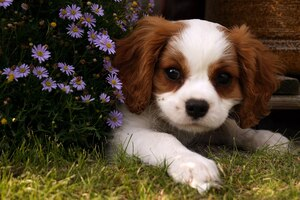

In [ ]:
fn = Path('samples/puppy.jpg')
display.Image(filename=fn, width=200)

We create a `Chat` object as before:

In [ ]:
chat = Chat(model)

Claudette expects images as a list of bytes, so we read in the file:

In [ ]:
img = fn.read_bytes()

Prompts to Claudette can be lists, containing text, images, or both, eg:

In [ ]:
chat([img, "In brief, what color flowers are in this image?"])

The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers or asters blooming in the background, creating a nice contrast with the adorable Cavalier King Charles Spaniel puppy (with white and brown fur) that's resting on the grass in the foreground.

<details>

- id: `msg_01PD8QEfpxGCTF1feF7ywUtC`
- content: `[{'citations': None, 'text': "The flowers in the image are purple/lavender in color. They appear to be small daisy-like flowers or asters blooming in the background, creating a nice contrast with the adorable Cavalier King Charles Spaniel puppy (with white and brown fur) that's resting on the grass in the foreground.", 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 72, 'server_tool_use': None}`

</details>

The image is included as input tokens.

In [ ]:
chat.use

In: 110; Out: 72; Cache create: 0; Cache read: 0; Total Tokens: 182; Server tool use (web search requests): 0

Alternatively, Claudette supports creating a multi-stage chat with separate image and text prompts. For instance, you can pass just the image as the initial prompt (in which case Claude will make some general comments about what it sees), and then follow up with questions in additional prompts:

In [ ]:
chat = Chat(model)
chat(img)

This is an adorable Cavalier King Charles Spaniel puppy resting on some grass. The puppy has the classic coloration of white and chestnut/reddish-brown fur, with the characteristic long, floppy ears and sweet facial expression that makes this breed so beloved. 

In the background, there are some purple flowers (they appear to be asters or similar daisy-like flowers) adding a nice touch of color to the scene. The puppy looks very young and has that innocent, gentle expression that Cavalier puppies are known for.

Cavaliers are popular companion dogs known for their friendly, affectionate temperaments and are often considered excellent family pets.

<details>

- id: `msg_017zQdx8LLod63Xzzxpqe4Ba`
- content: `[{'citations': None, 'text': 'This is an adorable Cavalier King Charles Spaniel puppy resting on some grass. The puppy has the classic coloration of white and chestnut/reddish-brown fur, with the characteristic long, floppy ears and sweet facial expression that makes this breed so beloved. \n\nIn the background, there are some purple flowers (they appear to be asters or similar daisy-like flowers) adding a nice touch of color to the scene. The puppy looks very young and has that innocent, gentle expression that Cavalier puppies are known for.\n\nCavaliers are popular companion dogs known for their friendly, affectionate temperaments and are often considered excellent family pets.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 98, 'output_tokens': 151, 'server_tool_use': None}`

</details>

In [ ]:
chat('What direction is the puppy facing?')

The puppy is facing toward the camera/viewer, with its head slightly angled. You can see its face clearly with those expressive eyes looking directly at the viewer. The puppy is lying on the grass with its front paws extended forward, in that classic relaxed puppy pose. The beautiful purple flowers are visible to the left side of the image, while the puppy takes center stage in this adorable portrait.

<details>

- id: `msg_01BmxwrDmHkZt4CfBzjHJuU8`
- content: `[{'citations': None, 'text': 'The puppy is facing toward the camera/viewer, with its head slightly angled. You can see its face clearly with those expressive eyes looking directly at the viewer. The puppy is lying on the grass with its front paws extended forward, in that classic relaxed puppy pose. The beautiful purple flowers are visible to the left side of the image, while the puppy takes center stage in this adorable portrait.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 260, 'output_tokens': 90, 'server_tool_use': None}`

</details>

In [ ]:
chat('What color is it?')

The puppy has a classic Cavalier King Charles Spaniel coloration known as "Blenheim" - which is a combination of rich chestnut/reddish-brown and white. Specifically, it has a predominantly white face with chestnut/reddish-brown patches, including distinctive markings on its ears and around parts of its head. The body appears to be mostly white from what's visible in the image. This white and chestnut color pattern is one of the traditional and most recognizable coat varieties for this breed.

<details>

- id: `msg_01LbDojHChVpV1CV1sHTsUmt`
- content: `[{'citations': None, 'text': 'The puppy has a classic Cavalier King Charles Spaniel coloration known as "Blenheim" - which is a combination of rich chestnut/reddish-brown and white. Specifically, it has a predominantly white face with chestnut/reddish-brown patches, including distinctive markings on its ears and around parts of its head. The body appears to be mostly white from what\'s visible in the image. This white and chestnut color pattern is one of the traditional and most recognizable coat varieties for this breed.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 358, 'output_tokens': 119, 'server_tool_use': None}`

</details>

Note that the image is passed in again for every input in the dialog, so that number of input tokens increases quickly with this kind of chat. (For large images, using prompt caching might be a good idea.)

In [ ]:
chat.use

In: 716; Out: 360; Cache create: 0; Cache read: 0; Total Tokens: 1076; Server tool use (web search requests): 0

## Extended Thinking

Claude 3.7 Sonnet has enhanced reasoning capabilities through [extended thinking](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking). This feature allows Claude to think through complex problems step-by-step, making its reasoning process transparent and its final answers more reliable.

To enable extended thinking, simply specify the number of thinking tokens using the `maxthinktok` parameter when making a call to Chat. The thinking process will appear in a collapsible section in the response.

Some important notes about extended thinking:

- Only available with select models (`claude-3-7-sonnet-20250219` as of May 2024)
- Automatically sets `temperature=1` when enabled (required for thinking to work)
- Cannot be used with `prefill` (these features are incompatible)
- Thinking is presented in a separate collapsible block in the response
- The thinking tokens count toward your usage but help with complex reasoning

To access models that support extended thinking, you can use `has_extended_thinking_models`.

In [ ]:
chat = Chat(first(has_extended_thinking_models))

In [ ]:
chat('Write a sentence about Python!', maxthinktok=1024)


Python is a versatile, high-level programming language known for its readable syntax and wide application in data science, web development, artificial intelligence, and automation.

<details>
<summary>Thinking</summary>
I'll write a sentence about the Python programming language that is informative and highlights one of its key features.
</details>


<details>

- id: `msg_01WzrZSz5ifWMRAM8bKBd5Qa`
- content: `[{'signature': 'ErUBCkYIAxgCIkAR4fKzB7dWvGAAwxx7Xa9g64dFyDnI0s509486TkqPHnBjFRt5OocH3D76O1wxYXRrwtAAZhExJ2So1KSWCAcHEgyioTh4oozgJV0Dv1UaDI9cd01uZNcmgTZj5yIwxFOU30dv0hO1z6N9mYjKWOROtwn8ZP++yokW3097IZHcvII1hcFpGpjLLn8gJRwuKh1kLMttnNoiCV9XvPRpLgSclyQt2IaVtEar2acEGRgC', 'thinking': "I'll write a sentence about the Python programming language that is informative and highlights one of its key features.", 'type': 'thinking'}, {'citations': None, 'text': 'Python is a versatile, high-level programming language known for its readable syntax and wide application in data science, web development, artificial intelligence, and automation.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 41, 'output_tokens': 66, 'server_tool_use': None}`

</details>

## Web Search and Server Tools

Claude supports server-side tools that run on Anthropic's infrastructure. The flagship example is the web search tool, which allows Claude to search the web for up-to-date information to answer questions.

The web search tool is currently available on these models:

- Claude 3.7 Sonnet (claude-3-7-sonnet-20250219)
- Claude 3.5 Sonnet (claude-3-5-sonnet-latest)
- Claude 3.5 Haiku (claude-3-5-haiku-latest)

Unlike client-side tools (where you provide functionality), server-side tools are managed by Anthropic. Claudette makes these easy to use with helper functions like `search_conf()`.

In [ ]:
chat = Chat(model, sp='Be concise in your responses.', tools=[search_conf()])
pr = 'What is the current weather in San Diego?'
r = chat(pr)
r

I'll check the current weather in San Diego for you.

Based on the search results, I can provide you with the current weather information for San Diego:

Today in San Diego, the high temperature is expected to be 67°F with a 4% chance of precipitation. The day started cloudy but sunshine is expected later. Winds are from the west-southwest at 5 to 10 mph. [^1]

For tonight, the forecast shows an overcast sky with temperatures dropping to near 60°F and a 14% chance of precipitation. [^2]

According to the National Weather Service, a cool weather system from the Gulf of Alaska is moving through the region from the northwest. [^3] [^4] In wind-prone mountain and desert slope areas, west/southwest winds are expected to be sustained at 25-35 mph with gusts of 45-55 mph, while the most wind-prone passes and canyons could see gusts up to 70 mph. [^5]

The air quality in San Diego is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure. [^6]

Would you like any specific details about the San Diego weather forecast for the coming days?

[^1]: https://www.wunderground.com/weather/us/ca/san-diego
	"Radar · Satellite · WunderMap|Nexrad · TodayFri 05/16 High · 67 °F · 4% Precip. / 0.00 °in Cloudy early with peeks of sunshine expected late. High 67F..."

[^2]: https://www.wunderground.com/weather/us/ca/san-diego
	"TonightFri 05/16 Low · 60 °F · 14% Precip. / 0.00 °in Overcast. Low near 60F."

[^3]: https://www.weather.gov/sgx/
	"Last Map Update: Fri, May 16, 2025 at 5:06:38 pm PDT ... Onshore winds pick up this weekend as a system moves through our region from the northwest. "

[^4]: https://www.weather.gov/sgx/
	"Read More... A cool weather system from the Gulf of Alaska will dip into the west coast, bringing light rain for much of the coastal basin but likely ..."

[^5]: https://www.weather.gov/sgx/
	"West/Southwest winds sustained at 25-35 mph with gusts of 45-55 mph are expected in the usually wind prone mountain and desert slope areas. Most wind ..."

[^6]: https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628
	"The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos..."

<details>

- id: `msg_01TRx1TJwJUqoXRXy8DKYmSV`
- content: `[{'citations': None, 'text': "I'll check the current weather in San Diego for you.", 'type': 'text'}, {'id': 'srvtoolu_018gmD6VzokffavRnJcGoy27', 'input': {'query': 'current weather San Diego California today May 17 2025'}, 'name': 'web_search', 'type': 'server_tool_use'}, {'content': [{'encrypted_content': 'EugFCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIZRJWZkUqSf7MecWxoMSAXWDyvWhdpmxdgvIjCV1saRsoYPmdG1pXqGpsyTlXLgjj92VgI/TwziZgiFUHh/5UujY9nx6v8uBQotnYAq6wQd6zuGxEUGHNbXnA/xZkXurHK83xgg6Cn4MuY+KAu1ctKgpLXmjeR+fKOjKoLkNYVBdecTM3nVyJ3hUfhsNjOZ1rQwCmL01c63XVZQz2sFunpSAU5zidD9s1loYhKTQb6VHzoWc6qEBpHpN6/nro5BKDHNKSt/F6TU6IdFQuHxRjDpmooHa6yJQsrH5pI+X2fFX5s9a7pLwi3DcC+/WtvGuGrOnsMB4VmfE22dgrZhXwQojFfGlFmjmAJSH5yFWv1jFiFI5TUtKFP4+e7X0mZ4ipfi90iufD/FP6SpWVUUbI6g1vbB/BdaXX8E7b92yykcCToKGPskVu3xLE//F+Nd1MEloF3NqggRt8du2liTRgXyuCHonM+lFRhhoiO3L9xscQnH4zg8+Ft0aZSsySRLvFmEQFncfXF9gr1CLlFCvokP4FJsuRXpF72BqOLfGAHslzmQOEDLy58QhOcVPbD0/mn8hggvVW+LflIz1eLad952exzhJfolEaj6GICC3x+1IpMHhxlwRh6ImPpRH2hFXELYAioJHwIFXmTYlLmaJilIMGOepuh5edOggKF6Q9RCgJ+cwFuWqcBvyZ0RN9CDBPNSugIfxNfjEtT62mR/y1htmDRpgfMnRJGzdsVF7WcHY0oUhL6ec178XCWhkybCfh1OM2CZKU3MuO5+P/42BmjMPjJOF4rikqMd5V/w0LEXf8qxo5NyBuJz7C0f3YXb0H95oZ37v6kKze9ON8Jc6u++wrrC1ES+zJY/PCb5a1B1l3t7qanMCjuPy7WqlJDWqZ6FFVqFnmQL6QsR4+tXDR/CG7JiFcIinrdTGAM=', 'page_age': None, 'title': 'San Diego, CA', 'type': 'web_search_result', 'url': 'https://www.weather.gov/sgx/'}, {'encrypted_content': 'EqwKCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGvtsM6VG9tpNZXz1RoMemOR/IHQdvnDRnCIIjCHJKuoXKStkg/nAJIW6a0zEO2lKOSwev41p99HLly38BFy4KaB3y51KpGdQQU1YbYqrwm17ydgK+tzx59IUdhXVYLlQ9klKITX1TpY+dRTQbwnCw127LRins7HfebKaK7PvHF/tdUOJs9eKW5wK95ZVAuLQnlzimZtDfIg/W+Xrl9oMOtleaWRCZWgPtBOJCjc0DioDKo5MnJJtOVDSK55fkULQBgopqqEK5rEMD1zCAl+fV4mY14vOuPnaufQ6IzPZ9+PeIByjsJW+kLVZ6NMVWpkgodi2mI37bC8fFHxaekNqQDc5qQR0XAjfVDemnZYpCnvmZWpO1FmMwUYKzG4z4dwtMhZ0TNsfjDpQnXNjDsNWwCbjM4OcPzNk9E/GTnJCBtIvAnVoHOKUFTRvKhoJpx1K4Vvzxyb0FXuh40iVUKhdxscm4/alI4z26JTSR70OVeD+jkWe9zl6ZhRJ1/kM+jOubMw3bMYN9B/lRxiBKLx/OIO6JuIDYINDj3LpB3ZffTZnDp/mVND9y13hO+M4TncaMDbQVMywV73s7Emk9PKXzOnPXT8O9PYIndHeL4p/iSzNjRzO2trRy3xhjX/tBonVtfD7xvPrpFtIsiIa9iZJMs9/ZQHhDhwhWlECVkYDM7moSzCbaVxj81mgCs31CP9IwMBFcQYr76GsFK3RRlMVpuqQS5M/R3QOOeKidL5uXWhKtTMODTlSd2Ceb0nO6hRirpMr+D5sYS3mlEfxFu1gPkhBVSi7o9n4lPJe5FDPKAgQAJX68f7HBLqrw7cVcl4RvDZxzTFVIkWo2PX/B/M/B4Mn0xpoiMX7i+GLVbhoGob1tJmXWpgysSzyoN2OTCId32W1C6ytCKBs8emY8+VggMeRKWbDFS8dQ7OhRLeQLQoh72ufRWgc5FAXfBAPqRCsoxaEqjkuB+Dql2wjtKcmu5g7we8lf8J7Zm/JpkYCiR7/J0aDhR1IRWoArCJB2Wrvj3l+MBoQy5h3K0j9oPLIFf8axQSOLPEWFEwg6/LrVQtBB7AKaokoQhAaC+VoCDjnAYflw78JgTuwnwQzleuEvsNGltD2zcnnvt7bItrruywwQINXTUbHuB5IAIuniynJdj0pKxBOAlHws456cW8WgLdqbCaOuossNNTUlTt1uO4Yg+KqJGEn05tI2o9P03sfE3X5nGodXxm3FXx+Kni42k9BOT5yGc/qAFZyELCqGws8xHSX558WFFK67sbOubGEPHzlMaAPzEMenzSZcLpx2hoWoBPiIfdjgf+mGvw6KBs3RzX0pS+HOMRELsuQT8YfveqvADk2iB9GxL3RG4uCm3jsJi3MNIhDLlejXpnD9s3j8b97gQt6btg79Lr+MBvaTNaRrSzAJweooaMsv3q7j0hUNV1IweNPjOf3zz2x6xAo39EWchGg7pr/XHNvRp/p0oLPlNrZnHm9U4DaoZ4Erdeoe3okiCnfjwEhnnult+VD7WS5SBze6My8Dfx/CHnHyyAaZTPRtYfm6UUeAM8G04jRDMiVnIRYXLFPuepiFBm+DbtwsNFirD+KRV1cKMFESCCgoCxDJJE2LMp+HX3s0lx+8G3urWK0kxoUAAEkg7Hiu+gGPwuS4VpE7qSNcKaFN4XDnnEVjp29HPAbHdF1a3WxLpOycNAfVW7sYZLtxgD', 'page_age': None, 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}, {'encrypted_content': 'EpoDCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDFDKg5GuBKb7ExDUsBoMZAl3TGHGrVvz4qgVIjDjTd8f+wp9U0ut0tkhoLR5zhH5ikXNuh1fVobf0SKOq13cNl19I9Jjyg2i2MH/6vIqnQLBFShB8HURB0OXDzWwHnOK9sFH4yyThYbOD4BoTnBeA1m5xjRe/+jxgrDpXMHnaUf5nf715TrpDutnKohGLWgeiSO6N0dwD4UofyPYnPqJaa7TLhjZQjAhpBBwymnrjtOcOakntNWOzyIwvO3a1B/kdXgB+NYWa8sK/+dJhLc86JqC7MAIYVqonj6A+tTvesT1IxyIP70q4MJVKS4OMknq80znYlMSySBksZ8T9ohxFt8sT0B2uJjV7xF+K9/2rFPOIKUr5/bwV4RINU9l1o+ZRrZA3VhjzAIWZbiE+0qs680oBZc+ZZ/EE2jsrbhRIUSi8sYUFraHll0D427qlE7FYOVemGW6KNnyoyocpITDaxZTp8EMnLporwYOgLcYAw==', 'page_age': None, 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}, {'encrypted_content': 'EpEFCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDO0VKs2fOUfsSF4UmRoMzLM8zd1y7KkobC6fIjCh7IxeED7PylrW7YlpOfe4xwLFFydAw13IL1pU1hhRxIrK7HhxYMYNq61+lF1SCcEqlARWygpNuCjv81ADRNheQRaGWI5Eit2updhUpj45pU4XWPb4a+Csi5FTQQE3v5jWI4W4Vbkc2ol3jQNp0/CGs/ZFhagwaHj6Dgq8wezTmIbm56CL2AodpVZ6HSkJBwIJcDwKe39/UZGz5igG0+h45qYxeqIgh288BeoFm6F+gk5Nlcd58YhdwJBCpMPNKRZQSsuZQojLS62XSYEGZWC1QZDBzKhhM2Ve7/LQTsJZgnJ7hCvgCA/hqp7dKiG5b5DL/xX63nwPyI7dt8MQd7fdGgkzyLQUKLkB+C5MelBs7hBpEw0ufMXZohQ5CsQrbCA/+xZD8OdMjoUSosV7DzRMVT5QzJ7VCQE5BUM3wqtF4PeCe6BXJAFGoOVvzBC7rhfmnLoOHnEShzAuwjRHqi260yqTEAwAzIWKCZOaEi5NyDHdx1/Tp5usBpn/n1PsDbh0gezLlMRqwjMfyj9TEpaIh+b1VPmmCOmp288BLGnj26su7HPN9TS8pEtnnrnPiE71dhT09X4zpmXHLIlnsyH8HD6+9V1Mg72fKaQg9zXkMt4kptjscM5fbMOGa/fCmuTtvxeLUyPL82whGfHUi9YTxy4S72acGCoP9PrcxCWHsCClSra3SJMT4Ehj1bOtrFKdQpufkBZYm0v6iyxe8+aoyaKRAcrhKn6JXAf/0OLK0j0nOf+qwMWQRbT4Kd14qZO9ohYldegjGAM=', 'page_age': None, 'title': '10-Day Weather Forecast for San Diego, CA - The Weather Channel | weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/weather/tenday/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'EsICCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMhaOesJAVyTfSp7WxoMUO5H82ZYM36p6at7IjDNMEmko0ztWlHzYfnO0pp0lVaYPkrN617u5V8yvDkwX3QfyJWJGy5VQxL6uF3UQMMqxQEqQ97HX1jKlNFWD+F+7WKyAi4xM/B7yl16lEqyUUYS+SVXW1pRiC/tt1vYxK7umyprVqts6njp4e+wmBwrdgwlZn/Dt0yHMS2swQMh2rJXTII4ODgcLx4wRLbOe13GC18js17cTX7hj0pAJd86I/E/JpjEa/w547dQ9CfJzOV8hLrzPkTR8kMExTeqY9lelK7RGYoArQnkD/rZB6tJMG9UuyvESoktAd2H9s1/R+mEuB74vjRBoy2MMOl7ReQalhpKWmnT/BgD', 'page_age': None, 'title': 'San Diego, CA 10-Day Weather Forecast | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/forecast/us/ca/san-diego'}, {'encrypted_content': 'EqAFCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDNoitupHI/bs1lDKfRoMSjB+djH1ZqUSfGVlIjBgnoGlFAsyb1FwdPeRdtDy2gaUNwy38PyCqiront7R4QUwuh4QlAGxw9gpPm6g1ScqowSUK+xQ+vpPvaNLsxhrHXIrNA1mU07a2J7/X8WueLKJ8O0t/5mmJyeN0GNPzedFccqJzlZjMEb4ffSuJ1z0q1+xQsBhLcRHSBrheXR0BLNXiLc2kGiwt64TcIi8pzaMRHerMJduqTE6czyS6a+FE9+SR48/KsTi2niKGU0I2dIB421p7DNVfCKpBs6hLbv6ap/HMUt0ut8znNW55TEDwAawB93loJq1/TryEtLb7pX4u2DQ4EyuGnAEOQtblZz6FizCQxj6WA55JCcw213ojG/35BhsjLyBKUhILXE7Q4cpjhWt+qE3cbahwA8tuW2GvD7hKW2mlp0J6K5lWc6D4/VsIskmWmn2Ga7T62TTlUpKqdWVYQo2AXQqC7pGnAbUlzyDoj2oiifjEJlst1OhX7+XSw112Ko5e0448mDyXeAzxwelBRRKVkLrTf2JOXi7J4edLphTcDRhN3geyJ3itvYj/zey//XHzU2r6WJnJw0HdSF21PmpUC1dnEjp1kFCzTbAfY6VtYa0GTbv8+L0VVEUB0Q6RKHMLi7BbLsui7wwlv5dHEAZEizxHJMZFjd598hUz62ZyB3Vn9Nd20qla25IpieIUcr1/o/XYngj6NYgrkMFe3cW/s05QJ7n7to/5oOgrGCIF25F5sa1pF2Lqs/dRzUayz79UaJxajMbv5YJ+64qgQc7pyCM2UrVWLfU81/zkOfilJUC9O6IEsev9us2alZcGAM=', 'page_age': None, 'title': 'San Diego weather forecast – NBC 7 San Diego', 'type': 'web_search_result', 'url': 'https://www.nbcsandiego.com/weather/'}, {'encrypted_content': 'EsUJCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDA5yYjKMQfxb/vJt5xoMymGHYhGnDYECSztrIjA0nc1lJUUWDPo9eX9awYBMCgNCWEXCvm+KSHXYROq37hZSosPWZy/oBmw07SIxmBcqyAh5E5KASf7w7AC9pikdcnUDUSOaodK+2zX/Jl0rFhjavrYR/QEOQN7OT02YjQrG7CwwrW58D6SnfZ/q/s648OwEzD2wJKHNEkMccPV+AmtwgCTe0dY1HOwF2kgQKPDCcddZnPMotyG3lPmBtD/yuk+1ErWuDhkQWxKkUosF2+uJXOQXVYQsatiDm17rjP4Tn/2YljUUvnzdEuwIAE94D7U+pTEIv8CKnYBsih8J04WT++p/q6GSc2qdU0qTYUfE5ovioMRbE777B0XoUoIjUyRyIds8JMEvYjuWN1ECNM5nFbcNqJ2es/zKgDmSTUaH/3Iyzk7AyfwIu5Pz1ezJ2TMc8f2SAXMeieaqD6lA7GY8uz53Fs20KtUcq6znk6bu3UnRy3yROw4zp3iEteAZFpYTA6kW/tD0MOGwrdF7qMa27+0Bq8vSUvTXPcwY/wBMpFk+JHPIpLuXxgQvzW5kMA4Dc00y0I1Ywdw1ohOv8kAvDsO25tpq8fr2mAdIMx5gT5rDsw0Zn8er0bbXkfEnbzn+rGoSCfthJrDvSjYrjn1piqHg0x/ckGOdaI76XPlVdRYhMZauH910k/Y/e5fNs/NquhqP/yFQ5DuQ4PQGNnE2WZz1XTS36nvT/3DQFVcQcwSM6VcQul6vfFpjad0UptlcSFXqqjbCtQ5XACUYRR4xVNBsSaSYRV0fAkJYIWLf0ZcKzfai5UsQHyneLXfOJcy8AeMbcib2VqmWBxMb/PxoVUUydlgFdFuZElNrN0kp20qisKvouYKiy/dJjlxDJ8d20T/otCSRK3iobRG1aQ14accb9gKofsExkx8xSzS0kJmIeKpTqoArn3mMzkqCCk80pjW3CHrsUvdJBxQWtXDblzwu1DrdzpGqjAiZP8hQ/Om7z136U5oHDwfgNIQId4A8e7Rwtw4AT1tjmf3OUBHVhEphJ6LeFeU3n6X99EhlzAx9Fsr1TPQY0bv0E6YvKzwJpITOe81s6TghhqjZl5ZXwypjbcWQGbH8AidLz6QSrHcTksMpe8Ta8A+sXiflfEYLfmQgss43XtgZS9QGJuG8wSFFvY2A+G+RQOhMdSs7uW50HCvUR3yeaNBQ6CbIjeNvwK/20MqofKm5av5JHa7dw/UpPUMaelybSLK9h9BH7PJC63Wr2IZdCK8zMStY15dg7NKGEBxFRetAHf5SGYslSDUPQkRCjJAOGRcESECra3a/Z8/xarZ4BF0GzO3UHARzVNjA1S6b5DfL7iZ7PKcyyGDP2st8FzQw2In8YRSA3K5XBNzGgBunu2SLJ0+gkCgrK6+DQmAKQSynh6XRjYJtsHZy5RIO4zj9Pab2oqpf+CLPUme5mCwkZd0CCwOcriGOtRmZ8U9DWR4IbQtLuZLT9aJYqHk9r26z9Nj9GzQmAzTPgsKEj48JKV33Odo12Zf6jtHACa/fTpHpQj5OJfgp7fPH1S2dWlPyGAM=', 'page_age': None, 'title': 'San Diego, CA Daily Weather | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/daily-weather-forecast/347628'}, {'encrypted_content': 'EuIcCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDPgjlyBMDPwZ/wzqnxoMSr9w+icdkgNiY/MTIjAaOTjw/8BMWJUHVn1/BJpBdEw7HI+epHGf3F3HOLfVFWgQKdaciF+f9abVgFvbnYcq5RsbUGmfICERcs4MfAXsEW94TggN+Zkc5bzbE4hcYAlwZL6lL29iVmSxCniciYqMukbNH9LV/lRrATsePQdqHcfQMHGbYUwtv8GNK36VUDazGnoeYiH7feXDD45dIr2yRWWScCrdSdbxAoB4yj9SRTKew9CNHDBzExQUePlkzRfEDm22IaS4rLnGjZY5qfW9MECA2ctBmpVAdp3aLu9mG037/nej4WdwBv44QgUVT+LzHNAXGYIlubazwGEAfviEIOGvjiZh4kB1zgsWA8/Dh/fq5ITsJsmma3ghFY/bRejRwnwND1vCit3XMsafzeZASmrehQPFDMuxmqeWtjqrD7qTVsNwV7Sav7d6M4BjCmer+KKe8FirBfHwn+Oi5cGTn/ImJKCwIa6vcAjOHJfKIibTaoJXZzx3TcqNATEeOZnKs05CGv0HqwIhYiCrd0RHh/52kHVUU+UP2S8XuLF2s/A1io9s6YbNELKi2krPFTtmKa5mFIhPd5qRmquHb+PjHZbbJNV9Z7D1mIdLFvV0ZmgJC+u9jESb0a6FZOUBZdagnqCYv5VMcBFX3LujjE8yxyPE5HU1InTpnIQzdotX3EEnqfrifArqGTYb2FMSy1ZRjY4BGv0lWgT4oi3E9LjxXFcRWeyy5UTQjo1wJp9obsKEVhiRAx2o7VOVGaTXsDlcREaUExJUH6BuQZ9Chu4z0xR0uEIjntoIIrRBAsARNARF/wgyuNT3/z3QJ6Tx5drODux8NJ+R+GfN+SjtvScmB5UJ1Jmp5VHfNtgKG8aYNgmR9bIvhR0qcP2DDj1ADBjyExozaY1rI+fyx/+dbQzZcdznzRgBsCQBF1YDsLVWK3F/1Zyo+3k/GkQQTY1bDHDth2dvf6Er+hzXCFTeWjYbec3IMbY7IJWdt8BXVr4gRlwn/cx1SbXd5pjKeY97Qu91Qw8Zposuc99kv856cSkwsDrN1U46DiiqJTU+v27cEoJsGgKxrER1xaQKqhxEuZlrgnFSjvCZNDIKWqWpTbTrBWIGPKDLMn0XKAvYFP6iLZeYy9pJtPMYAxEQJdD7EhSg0HWalf/B+u99oMCcs9T8luP9CI+p/MOuPwa/cQmErVVQMNLV9rU2+6jXFRzyuBb2D1YuxBk43Isy78g7+4Z6q2x8oiRGIE1Yv9aP+KpiG45kWAUsGEui0Bm73liwki6095LDDBs1PSThvSU7nCmnRC9ohXLEywcJ4yE+NbBv4vScU+W8yy4Wcr+Ti77pZtj7BdexMe7xy7xJ2EkXzrezRlz+Ipr5QRg30hSRw7zS4fm6TCmE8dY2OenC79aEpct5DUNA5Zm0DNYGcxhOX8AMYvzKhPbg+BvlwBz4XFeNKZIhu+UoS1VlYoTcWI8kua/6StLcqX5LpOZblk1J8s3neSKUlChlB6+3Ta2s1+VmJAB7MvJFKur+GBVAFg2i5DJfiH05Tn9OPZ4RlqkJ1tqduIrdri9GqHQqjO4iXLABYesZ7jjD9tPYl+xbV/pnQD99dn91wHVTCAqF8EsBHiWZYae8K15HY8Y3tQyKB1C0RiTeAHXR1X8k6AEYDnSN81DSYGPCCriNFVODwd3ZmbED+SUuNJ1L/h3qkSoJeZaEybfLSlVZM9zRGqqz6OhlX1ft0WzZuLq9nFM9mzreqmHxes5ViajwNKe4JjG9vT5cRRqakTUZwuJq8jPOB6/EaUVnnNOib4C6vGCgVDg7moySA/kqEQlAR/wM+eB5FDCqBIljxweIdz/fU/q5o5Cw9HMGsS+j1NmRXx5G6S4kFm9T1vnTk6/YNi+vvrVKwftHTqGuxN+L89rqXD5Qsf6nTeZ3T7zQdURgW/0hD2Ga245SgNMvZ914FsQcMzoUMa1/rGkxi/5evMLorT6WaAGxHINlFayZLfX8/XjJ/BxhDEiBBlBNDh8lAsRjHzayPgcHAnpYV6grYIn9NWqDJtwxzg0fkIUVKjKKR8sxg0+5NyMDl8rvSkTSJH9NgTSep7ZcRxhWGa88fPwQ3wGnWxjZ9BCVs0VpBL6jlq19GW11Rp/BreAAmo3pb1lVjunkjBBwgH+dO8ZDuElI4uE/iaAknUWgyITBeZgtJo4dR/vBn0TWsGDqzR7J/7XFoHkNq852bDKUIWFt03rNtxFGsIHOl3R9bZ2QIubGOP00ifp61+rBLHcdKPsAJCQR6T4zFfs6tuMFY5MVhtRkN455gEFmjhkG9Xd3ZGqfuxTk2irdL5cvoJMJxrCthXQyzw1B2Pyd53MsLpV9d8CCOU64yIgC9/ynlTbmTZ9tekW99AA4sCDvynw/5cFCV76ZIIBBZZz7dx8nJSZ6u+KFwWpxI2BsEoZsCdIiYF8DRweMjEWH0lQ4PFTXg9/5Yjcxm0vZ+U2QziMhR7HnNL2JGg1aVb4js0qGaZlW3V4Jm4ytiiujgm+NmDm0xaWN6GnoJxRqBaMkY/n0tMF6hbauhsKoLBCGEa83kkayh0UROkwu1nZuoPKBC1+QDvyijFTvCxXX7dBzh7u1tmFJZziCmbWYIMmAPKpUhyse8j+4W8Jx7baM0z1ciUGyyrEL+xRO71Yg74/qDm3QA1+w8rkpvmQ0ulWbIiDGeM7igG17vsYPUAan0PPC/cYHn9Y3N+yk7GoB0DyXrX0FodzMb/+0r0Z7NwHY7e5bRA0/UU/OgtqOqK6qONVVovJkKoW+0UjmuZTsZ+mHamfVEVyJhh6y5vRzSFOTkpVd+6fxZzw3XLt0gRZFGnBmkuOhPoIn11hss2hZ86FJx8T2IHtGHcz2mBMf+gTqBauElE1luKYzIV6fe+LVsAdi7T8klppvE8R6rrplhfHcfFUdaWOEb37FM3dbWV+mNUUjkf7NpmLimdHVoePx/cvkehCf9QiTVvN0fJeb/NaT11GAvpVOVTyxyfLs64aX6iM1XmfpBgfSQQKIOdh/W8WZm1HR8HMdso3zpGiFU6xJFGLee21yKMJF8wxLHskca7swLj6lyEWwnHbxnOPlR8d6GUEgr30BV4FZMY/sJB2/mQgY0zKlZgumLzpsnHbC9o3p4LPE3wAEfV1GPDsER0L4KOsxUsZfpNkZ+sFsnv+G60NJvrlFD0Fvr1X7Lu0CnbRa+nE8bBPLFFyEoafd2KolFtzuhizSqsWiAufuVYfDlcGnWGhNY9IFRk7geiuNU8rHDd+Bi/XlDtjbzc5xqRY6JndSZpITywTG9/L7bjU+IEVC86H9U0l0M8FPSrZS9PWFUhb5iG5E89tBoh7Fwn8N02VtCLR3abtsLh911IbsLATHNS1j1/wn4KTib7gHBIsgra+k8jiFIp8G13pMyFHtLeodt+tQxoQo0t0bUFEUgKvjzRBQfaOkrr/aqc95kpZ+uWYTHMQXCOcPnwfcSLajI6DhoXofk09BoEfexm7GkN9XUhRh9v3vwkZ5bUy+Qc/9RmNQnboOAGSCBDbzQZzWCvslHpVR1W+y6hNHvkzztT2gxSHseM2PuUa4Q1OTlQucsO6Y7f8a73ew+52Mh5/b3z4otamCUFppalUlZKvwcopwvDait7kqXJa08IbAndFDhEM2hqG2KJM6X5FTvshpnmM1ogaDJ057UwibaNtu6nLsHsjCcUP+jUU7uOyQ5MEKnpNSfwTmt19daDVjP/bTkvTcZSnTdyHiUh2qEA0DFoBVhkrwmhs5oS72s+0j6N9vj82s1SZqZMvlmfddTLoc1YChaxqVI4vpmVHvq0J2LCIw4MNWsPI7dJKDTVo43rM9OBXggiEioicyIffZ4BTEhhhbnHdKmlr+GP5P1uPHsJK6eLtDayBqljXBxsF6H1og0U87jBSxmpRSx4bg0yRpN2bmSaLBiZ9vPxkzLgufCFqQTZv3N3hkflytGpyTwlTCnGu+yVz944zuxaQaVSQ8n2E0C3ptCJlck0VH5ul5X/kvOEQd8jDHq59w73SZwnm0SUerPI7WVpPGxhTzrgIsRqTY+lRkV3Y5xBvhg2B0LfiZSRG2DCEhmXz1GW8QitUE8zvbLEC4iPGU/oVAer9ZySPj/VvQy4HNRfWH840gtCLoAHdAOr0TJ9si4MPENY1lvdQ7pn1AMDt6DLtV6KkaaWYxvfr9RvKsEPUjqQjRYE/rtqAnT36hABYgw+Bf6HqC7ykEMg+fFQKE6TyWIJuXgW7TkuNsBoxB12Z75I5oAptu07pr7bFEd3kb0Ab3IXABIbeEZCvMPjUQOvi6mq615wtRvKR8MnHQxGKANZcohM1h/RPUvnN6TWKuEM2GzrCZAwhzhRl4TGsUe789N6+NCDZ1K2caXHPmeL2fu0DBRB2bIyORzJHpl3s9fcbE5RPA+jrwhiFtCAPLXY1HEi43/koF52AnCajltZEHo1LCfBJ1BhnDeqbOb3XUZsBHKWzel32I8BSfP6M4H+jIVkCXoEewDfoovzRpWMFY0MUmbp9VwSuZpKfHOq8rouq/JyB/p9YzkVuh6B/4Vmb6PzYLCkpbjSy9DevSb2yeK0LUlPYoOeeUi31OPjtIcWLzE7LdipgwyoP4p0ar8aSejJhgLv8mq5gbKVGbA7R+b2sfELG/4xrowYHdi8pg3sJlyWVyjMxCPQbNYkRaFInt/uzCm6u4r5QUb/QjprYF45me/ZbDZiFfSnzScnH2sinqcbZgzQTDN69VxmLAMQzs63Fs+XsCsBcVS63GAj85iBeLuu0FTrquHKzvGhEioMxwVpMNxA9+9jjtYZzKiVxfWENpB2oeFntrcBgD', 'page_age': None, 'title': 'Weather San Diego in May 2025: Temperature & Climate', 'type': 'web_search_result', 'url': 'https://en.climate-data.org/north-america/united-states-of-america/california/san-diego-714969/t/may-5/'}, {'encrypted_content': 'EvIHCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDJNK00WnEWeSGbeFxBoMmHn7IFO6ywsRl/xWIjAau5ejVvQgU0NU5XK9FWKH2SQEH/Q2rDoy0d/LIs4fTyhSJZJ4o53MKzg3ttwCjqMq9QYCXY8fZ9pqpYAOR53xJxBLqWGcON+3NHz7LiSCI763D2ieop09aPiG1fJfFaLKZF2eqZqhBW9sqiuiFjAf2B2w+DK2ex7juMRlCuwYS2rEXjFdV/18fxDFfhu+IbzZR9ppq5vGykt2swu64ry7BtYMO8jggy3NeJTV8cvW0+xlVu/URbs+bc1UZBFuW/4zffqyUc3Cyq4xCDl4MNuoRoisgEuRhMjCw327QLG8pq6lJHrxkpp+qxblbNOXUlRoii+3X9CTahFTM/5aYwqijcnf/HEdX8Z1uqnSIxzhqSbupqHCl6ECn2svpxhm0PNEr8whp9YIkJqfMfSbIMkp8f9CeAO5PAIWrrnosE56kmJ9DUeh3+qO82fxLXxh6UOtWuh8+yvoRIPBCnozdKeV8PpEAg7ayN9PIR/zk8g0in4NAtanuYOZn/4OtdTRZOfP2AdoXgremQBzGGmxALFeMVaV4aYP+Gh+60PZy+H8RpLsvDMYdk+mG5MMy9FR7p7LPC0w4ykh1WpZiGKka/lWXsc6ggxGaFU1yU12B4hVqwRBK2flHgyCuU9svuc796u3A9KKgmv0XlHm7hxROC2YPQiLorjLYQuFbtmc5JyxqUsnSbxeimpzSXoMpbDZbTVm3ta1s+kSNX8tY3cQ7s6ZWWC7sQDik24dCvkASXctgwyeAkRfdyc2YfGBBGAzFYsvJ1Iv7q2dHFUWsiTzQDGn6LtvqBXhFWP9oK+6EtijM2HtKhsgVEuBMWMOnv1njfmhsIkJ2wQ9MKnOaSHIDIdPFn1DljKf1bhs0Zvn3Zunnpcy8Xq29c4jgco68N4JzRuixzNH4PepTJ6/BUZwHRxiwvEtB+yu9HLjLea/g4DvSEdSY3DqFS0sW4Shz8ysp+wpIBSNxIPaanKSC9p9XM+qmwiLtGGKqTheq7OMst75XS4tMNvASPwRny3S+GbRhwek+9QBMYoU0ClMLSKqsx4FRYP587J8OXhNX9M2hvAXQHrAdCdGw9wEVoxrM3xYfuOC/iwafCZ22ibhm+IBKx6ArrufXc1Rm4sUx3lqulCKLhHw8xybfWbXIwIljAETbtJu7+HWz41WpIjkvHjaARFkbTYIdXs0EV6mBRqTdAUmHeVh5mvCzQYxzgNjmB1gdjoh/sH0y2xkMdYaTC0chWUPeT9g1IL9FXIYAw==', 'page_age': None, 'title': 'San Diego weather in May 2025 | San Diego 14 day weather', 'type': 'web_search_result', 'url': 'https://www.weather25.com/north-america/usa/california/san-diego?page=month&month=May'}, {'encrypted_content': 'EvIICioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDD5Z1qWJlEnA2vNTGRoM3le3Z3DPX6c+UhAdIjAosSwZe/K35uR1jgwdnDd/8rU72RQNMXiI775FuFx42s2Y+jepxSalvLFrbQeleykq9QcGteM8HZ9RE0lzdJkUSh5vxmUduIqJrqlwD8StlhSJsOig67q44di3Xs8gtzmHvIk5V+Nc1Hsas90sYlq4z3nLHRvF46Q2G7qRUML70uUXfhUPj7xh9J7n4M1jwGEnhcr36FNQbZ2ZMeVAoAEVOsxN0lF5ccQ5QYpEptSvNXRKa3uGCKvaGpSAKiE3y52Gl79TFoI2ap6E6DMNc9vZH4Zjx/6HzUs9Xpe25MOyhSWslxznaoX2RWsNBXMJAp0enYlfUbuwosX1PvytKuO/9qrq5DgwNhlOEj4qVxHPjrlwxjhYfs8f4HIKMuwMHxLTX355aR5ZaVa3bcQjqAQyQS+1e3yRnG5Kg4dFLTzOPIleBTJR7uY+9Z6kPF3Zes94wxPjr+QBqWyrHz7y5dKRvg44VJpKwIZUjvSlGvNJPR1mVXknxC4SfkpTBbJ/siQ2gO6iRD4Zt6UfdW/ox7NNgU4or2BxuskH1pL/mmSlum0lPrpfHwkg+xDMM5KuBTRseVXEYFYolSRSbg/NdoJM5MDgMZ8S/ZbaqinJjyf3xaIzgHxngqqLMMPfV+GeP+Q/dkQw1lXbMfZ0fBGr2Mqjo7f6fd660pF5Y6qjtnXMrZZiSeG7+a+4/geUh0WUSeVy9mRmUpnlNGh+pT2jys12iWCtBGzWOqmAhfj5PdNZCHtZhefeVG5jnA9XqCC0nm+lOBfO2BRk1wk7jn8frfbGboJPdiQABij9wC5JVc5XP3mbkKr4roQbaThNi1nu/1rqImygyBE79Y77Wz9Q/XbqjtWyRr8nWXUG/hwiJq8hm77NxcW2F7Lm0npQES1TQv1r/3NKiVaaxYZU/OaNm7RO0jQeW0rVtzkuQ/GB9dX37jBbH/RPNraHOavWLVu7BWef5XquLNRJpLqhBywWGgal5Qx4tLZ+t2it41DQE2YZu+lRDdSrrhSTB/Q7qa1vRZb9CPG8OnaaUctG6REW2S4cEyvCoDOsFj9sS3ybBJN4AqbD8URu3gdnP4rqTdQASTcFBDVpSireT6kKsPoy7R+M4g0CXP8FxS29cvAQEEyfpb5ige58N3WpEVw2v0yyoMQ/RyCmVkcdKNLmmmdcVfWVIXQ6rvgCqyta0Qv8kNJ0rVhw/9RHIqriEGOPqPw0he+Y42o3p3l0OxeKqV9hZqlU4MD2OwUQoGvUOC6eQt+5zz/KeCtKD+SjMuYLKYoSi2Ik2AjEbdTYl70m5zs6l4ZA9HyEHnoIV4TqlAjrBTifp24ZxEmIcQVyfxKa7hgiEW6Cg9lpn+IIsvQNZ+ku+5KN9sJICWjJKlVnCrNPiUqY/Kk9lBhiNzsyX0h5iFSYW4hYbbFMjG6IcRgD', 'page_age': None, 'title': 'San Diego, CA Current Weather | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/current-weather/347628'}], 'tool_use_id': 'srvtoolu_018gmD6VzokffavRnJcGoy27', 'type': 'web_search_tool_result'}, {'citations': None, 'text': '\n\nBased on the search results, I can provide you with the current weather information for San Diego:\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'Radar · Satellite · WunderMap|Nexrad · TodayFri 05/16 High · 67 °F · 4% Precip. / 0.00 °in Cloudy early with peeks of sunshine expected late. High 67F...', 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDN9950a+HrXMli1NqBoMm3liLLh4nJOh/d+6IjBqvX1CK5+JwEsdZVgE8jfNXJ9VqJxqQDJ6iizV5S9ROvb7zyVMeu6wS8Xs+RD7iZUqFYLYqw3BozdgzQz8ectwx5cJN35oBBgE', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'Today in San Diego, the high temperature is expected to be 67°F with a 4% chance of precipitation. The day started cloudy but sunshine is expected later. Winds are from the west-southwest at 5 to 10 mph.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'TonightFri 05/16 Low · 60 °F · 14% Precip. / 0.00 °in Overcast. Low near 60F.', 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIbN/45xbK4m0KJw9hoMYMBo5ABxWT/7B9G8IjDT5OmNwcGXQYx8lz0Q+BbIY7zw5njJyZ8gyhxHiLwVwldvIdCo2l26TfNuyHUfLpEqFU7/ba0QfcaYf2k8BOiVIL8m79QzqRgE', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'For tonight, the forecast shows an overcast sky with temperatures dropping to near 60°F and a 14% chance of precipitation.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'Last Map Update: Fri, May 16, 2025 at 5:06:38 pm PDT ... Onshore winds pick up this weekend as a system moves through our region from the northwest. ', 'encrypted_index': 'Eo8BCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGJwYKTzHOQraelJQRoMDogYg46dqtuKWsriIjAhJ2AzMQqAo0vj44U2B4JzxfDcWC69PfKgoZoS2PTuk9PWdpJIJrhcjXfhafXpAacqE+rez2cpkv7Mx+yj5ESFuDVISe8YBA==', 'title': 'San Diego, CA', 'type': 'web_search_result_location', 'url': 'https://www.weather.gov/sgx/'}, {'cited_text': 'Read More... A cool weather system from the Gulf of Alaska will dip into the west coast, bringing light rain for much of the coastal basin but likely ...', 'encrypted_index': 'Eo8BCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMD98o33TOksL8ZOeRoMlueicwBy/5vixJ0NIjBEu6X+fmPuzCD7u31F3VS+M4TbCJrq06WZLkcvhKTk6GSmiEjaMRh0EqjUZtrIdjAqEw5cUhltNAaubRaRc/6whj/vT3sYBA==', 'title': 'San Diego, CA', 'type': 'web_search_result_location', 'url': 'https://www.weather.gov/sgx/'}], 'text': 'According to the National Weather Service, a cool weather system from the Gulf of Alaska is moving through the region from the northwest.', 'type': 'text'}, {'citations': None, 'text': ' ', 'type': 'text'}, {'citations': [{'cited_text': 'West/Southwest winds sustained at 25-35 mph with gusts of 45-55 mph are expected in the usually wind prone mountain and desert slope areas. Most wind ...', 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDxYWdkjMIi0Rni5QBoMF70EDy0MCIAnA1UaIjC4iM8iiTm+6a8IedemtyND13ayjuqAflH+lXlEupIBddXVYh6bGDb97SqexfLrcJsqFWfDWGJ+nlI4px+QT6nr7stnhmIprRgE', 'title': 'San Diego, CA', 'type': 'web_search_result_location', 'url': 'https://www.weather.gov/sgx/'}], 'text': 'In wind-prone mountain and desert slope areas, west/southwest winds are expected to be sustained at 25-35 mph with gusts of 45-55 mph, while the most wind-prone passes and canyons could see gusts up to 70 mph.', 'type': 'text'}, {'citations': None, 'text': '\n\n', 'type': 'text'}, {'citations': [{'cited_text': 'The air quality is generally acceptable for most individuals. However, sensitive groups may experience minor to moderate symptoms from long-term expos...', 'encrypted_index': 'EpEBCioIAxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIxoFifU5YqHBU4mBBoMCK6odbjtKFAV27VfIjDQ5JMBuOKGcZNOFf9E6dBu6OTqwX2KDxhxuqvYF1wZRoLpLJPuWzXO63eE8VETWWoqFT9bbhg2D8hmUphfeEj+FrX3x5J5dBgE', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result_location', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}], 'text': 'The air quality in San Diego is generally acceptable for most individuals, though sensitive groups may experience minor to moderate symptoms from long-term exposure.', 'type': 'text'}, {'citations': None, 'text': '\n\nWould you like any specific details about the San Diego weather forecast for the coming days?', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10059, 'output_tokens': 428, 'server_tool_use': {'web_search_requests': 1}}`

</details>

The `search_conf()` function creates the necessary configuration for the web search tool. You can customize it with several parameters:

```python
search_conf(
    max_uses=None,               # Maximum number of searches Claude can perform
    allowed_domains=None,        # List of domains to search within (e.g., ['wikipedia.org'])
    blocked_domains=None,        # List of domains to exclude (e.g., ['twitter.com'])
    user_location=None           # Location context for search
)
```

When Claude uses the web search tool, the response includes citations linking to the source information. Claudette automatically formats these citations and provides them as footnotes in the response.

Web search usage is tracked separately from normal token usage in the `usage` statistics:

In [ ]:
chat.use

In: 10059; Out: 428; Cache create: 0; Cache read: 0; Total Tokens: 10487; Server tool use (web search requests): 1

Web search requests have their own pricing. As of May 2024, web searches cost $10 per 1,000 requests.

## Text Editor Tool

Claudette provides support for Anthropic's special Text Editor Tool, which allows Claude to view and modify files directly. Unlike regular function-calling tools, the text editor tool uses a predefined schema built into Claude's model.

Important notes about the text editor tool:

- It's schema-less - you provide a configuration but not a schema
- It uses type identifiers like "text_editor_20250124" specific to Claude models
- You must implement a dispatcher function (in Claudette, it's `str_replace_editor`)
- Different commands route through this single dispatcher function

The text editor tool allows Claude to:

- View file or directory contents
- Create new files
- Insert text at specific line numbers
- Replace text within files

While the Anthropic API also supports `undo_edit`, this is not currently implemented in Claudette.

In [ ]:
from claudette.text_editor import text_editor_conf, str_replace_editor
from toolslm.funccall import mk_ns

# Create a chat with the text editor tool
chat = Chat(model, sp='Be concise in your responses.', tools=[text_editor_conf['sonnet']], ns=mk_ns(str_replace_editor))

# Now Claude can explore files
chat.toolloop('Please explain what my _quarto.yml does. Use your tools')

Your _quarto.yml is a configuration file for Quarto, a scientific and technical publishing system. Here's what it does:

1. **Project Configuration**:
   - Sets up a website project type
   - Includes all .txt files as resources
   - Configures preview settings with port 3000 and browser preview disabled

2. **Format Settings**:
   - HTML output configuration:
     - Uses "cosmo" theme
     - Applies styles from styles.css
     - Enables table of contents
     - Configures code display with tools, background, and a blue left border
     - Uses "arrow" syntax highlighting style
     - Defines a specific grid layout with custom widths for sidebar, body, margins, and gutters
     - Preserves markdown files after rendering
   - Also supports CommonMark format

3. **Website Features**:
   - Enables Twitter card and Open Graph metadata for social sharing
   - Adds GitHub issue creation functionality
   - Configures a primary-colored navbar with search
   - Sets up a floating sidebar

4. **Metadata Files**:
   - Includes nbdev.yml and sidebar.yml for additional configuration

This configuration is typical for a documentation website or technical blog, particularly one that might be using nbdev for notebook-driven development.

<details>

- id: `msg_01V7jKeNWkGSjawQWk8C1AVR`
- content: `[{'citations': None, 'text': 'Your _quarto.yml is a configuration file for Quarto, a scientific and technical publishing system. Here\'s what it does:\n\n1. **Project Configuration**:\n   - Sets up a website project type\n   - Includes all .txt files as resources\n   - Configures preview settings with port 3000 and browser preview disabled\n\n2. **Format Settings**:\n   - HTML output configuration:\n     - Uses "cosmo" theme\n     - Applies styles from styles.css\n     - Enables table of contents\n     - Configures code display with tools, background, and a blue left border\n     - Uses "arrow" syntax highlighting style\n     - Defines a specific grid layout with custom widths for sidebar, body, margins, and gutters\n     - Preserves markdown files after rendering\n   - Also supports CommonMark format\n\n3. **Website Features**:\n   - Enables Twitter card and Open Graph metadata for social sharing\n   - Adds GitHub issue creation functionality\n   - Configures a primary-colored navbar with search\n   - Sets up a floating sidebar\n\n4. **Metadata Files**:\n   - Includes nbdev.yml and sidebar.yml for additional configuration\n\nThis configuration is typical for a documentation website or technical blog, particularly one that might be using nbdev for notebook-driven development.', 'type': 'text'}]`
- model: `claude-3-7-sonnet-20250219`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1379, 'output_tokens': 294, 'server_tool_use': None}`
- steps: `[{'role': 'assistant', 'content': [{'citations': None, 'text': "I'll examine your _quarto.yml file to explain what it does. Let me view it first.", 'type': 'text'}, {'id': 'toolu_019f8tdh7b6pkBPf9edYWU3o', 'input': {'command': 'view', 'path': '_quarto.yml'}, 'name': 'str_replace_editor', 'type': 'tool_use'}]}, {'role': 'user', 'content': [{'type': 'tool_result', 'tool_use_id': 'toolu_019f8tdh7b6pkBPf9edYWU3o', 'content': 'project:\n  type: website\n  resources: \n    - "*.txt"\n  preview:\n    port: 3000\n    browser: false\n\nformat:\n  html:\n    theme: cosmo\n    css: styles.css\n    toc: true\n    code-tools: true\n    code-block-bg: true\n    code-block-border-left: "#31BAE9"\n    highlight-style: arrow\n    grid:\n      sidebar-width: 180px\n      body-width: 1800px\n      margin-width: 150px\n      gutter-width: 1.0rem\n    keep-md: true\n  commonmark: default\n\nwebsite:\n  twitter-card: true\n  open-graph: true\n  repo-actions: [issue]\n  navbar:\n    background: primary\n    search: true\n  sidebar:\n    style: floating\n\nmetadata-files:\n  - nbdev.yml\n  - sidebar.yml\n'}]}, {'role': 'assistant', 'content': [{'citations': None, 'text': 'Your _quarto.yml is a configuration file for Quarto, a scientific and technical publishing system. Here\'s what it does:\n\n1. **Project Configuration**:\n   - Sets up a website project type\n   - Includes all .txt files as resources\n   - Configures preview settings with port 3000 and browser preview disabled\n\n2. **Format Settings**:\n   - HTML output configuration:\n     - Uses "cosmo" theme\n     - Applies styles from styles.css\n     - Enables table of contents\n     - Configures code display with tools, background, and a blue left border\n     - Uses "arrow" syntax highlighting style\n     - Defines a specific grid layout with custom widths for sidebar, body, margins, and gutters\n     - Preserves markdown files after rendering\n   - Also supports CommonMark format\n\n3. **Website Features**:\n   - Enables Twitter card and Open Graph metadata for social sharing\n   - Adds GitHub issue creation functionality\n   - Configures a primary-colored navbar with search\n   - Sets up a floating sidebar\n\n4. **Metadata Files**:\n   - Includes nbdev.yml and sidebar.yml for additional configuration\n\nThis configuration is typical for a documentation website or technical blog, particularly one that might be using nbdev for notebook-driven development.', 'type': 'text'}]}]`

</details>

In [ ]:
chat.use

In: 2423; Out: 393; Cache create: 0; Cache read: 0; Total Tokens: 2816; Server tool use (web search requests): 0

## Other model providers

You can also use 3rd party providers of Anthropic models, as shown here.

### Amazon Bedrock

These are the models available through Bedrock:

In [ ]:
models_aws

['claude-3-5-haiku-20241022',
 'claude-3-7-sonnet-20250219',
 'anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-5-sonnet-20241022-v2:0']

To use them, call `AnthropicBedrock` with your access details, and pass that to `Client`:

In [ ]:
from anthropic import AnthropicBedrock

In [ ]:
ab = AnthropicBedrock(
    aws_access_key=os.environ['AWS_ACCESS_KEY'],
    aws_secret_key=os.environ['AWS_SECRET_KEY'],
)
client = Client(models_aws[-1], ab)

Now create your `Chat` object passing this client to the `cli` parameter -- and from then on, everything is identical to the previous examples.

In [ ]:
chat = Chat(cli=client)
chat("I'm Jeremy")

### Google Vertex

These are the models available through Vertex:

In [ ]:
models_goog

To use them, call `AnthropicVertex` with your access details, and pass that to `Client`:

In [ ]:
from anthropic import AnthropicVertex
import google.auth

In [ ]:
project_id = google.auth.default()[1]
gv = AnthropicVertex(project_id=project_id, region="us-east5")
client = Client(models_goog[-1], gv)

In [ ]:
chat = Chat(cli=client)
chat("I'm Jeremy")

## Extensions

- [Pydantic Structured Ouput](https://github.com/tom-pollak/claudette-pydantic)